## All classes

100%|██████████| 10/10 [00:01<00:00,  7.94it/s]



Accuracy per domain:
TRUST (UDIAT): 85.09% (97/114)
T-UCLM: 100.00% (184/184)


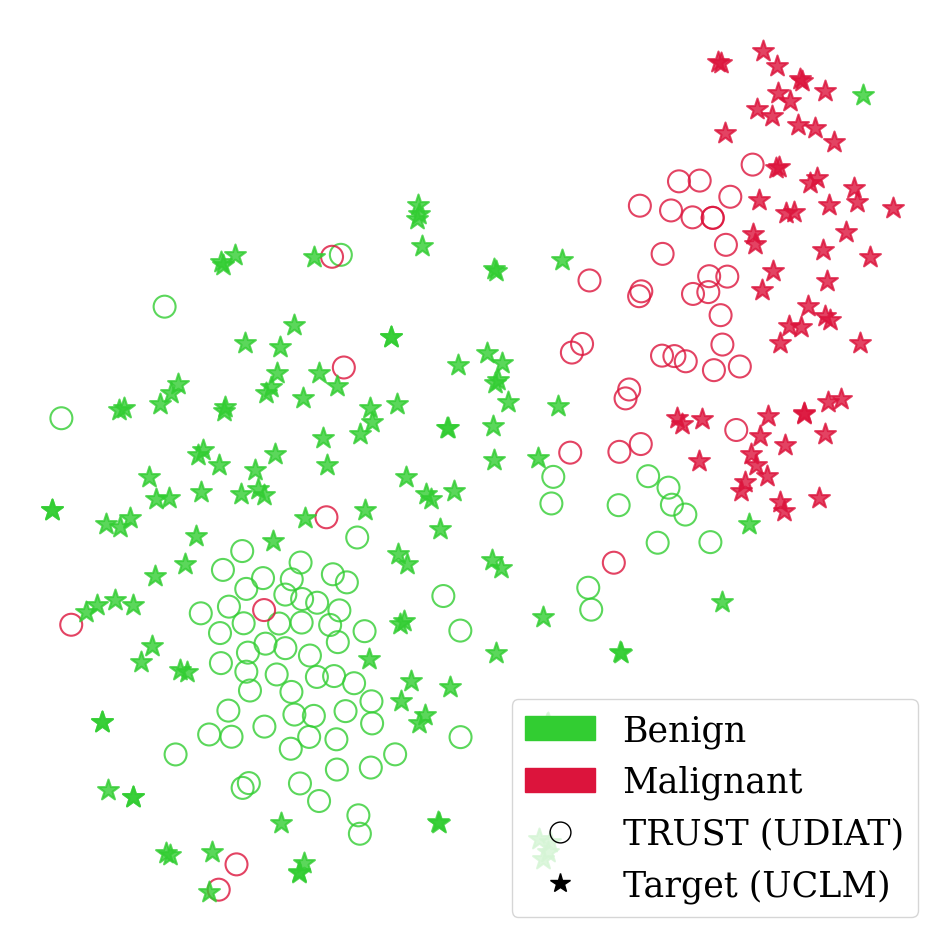

In [96]:
import os
import re
import torch
import timm
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import random
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
plt.rcParams['font.size'] = 25

# --- FIXED SEED & THREADS ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# --- CONFIG ---
task = "UDIAT2UCLM"
source_name = task.split("2")[0]
target_name = task.split("2")[1]
TRUST_txtpath = f'/mnt/HDD1/tuong/TRUST/baseline_TR_semi_AP/cp_{task}_TR_semi20_AP_1024/log.txt'

# --- READ BEST STEP ---
with open(TRUST_txtpath, "r", encoding="utf-8") as f:
    lines = f.readlines()
for line in reversed(lines):
    match = re.search(r"Best accuracy at (\d+)", line)
    if match:
        best_step = int(match.group(1)) / 1000
        break

# --- PATHS ---
method_dirs = {
    f'TRUST ({source_name})': f'/mnt/HDD1/tuong/TRUST/baseline_TR_semi_AP/results/{task}',
    # f'w/o ST ({source_name})': f'/mnt/HDD1/tuong/TRUST/dataset/Breast-{source_name}/train/imgs',

}
target_dir = f'/mnt/HDD1/tuong/TRUST/dataset/Breast-{target_name}/train/imgs'
checkpoint_path = f"/mnt/HDD1/tuong/TRUST/downstream/classification/checkpoints/vit_Breast-{target_name}/best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

# --- TRANSFORM ---
def val_transform(resize_size=256, crop_size=224):
    return transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# --- DATASET ---
class ImageFolderWithMethodAndLabel(Dataset):
    def __init__(self, folder, method_label, transform):
        self.samples = []
        for fname in os.listdir(folder):
            if not fname.endswith(('.jpg', '.png')):
                continue
            fname_lower = fname.lower()
            if 'benign' in fname_lower:
                label = 0
            elif 'malignant' in fname_lower:
                label = 1
            else:
                continue
            self.samples.append((os.path.join(folder, fname), method_label, label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, method_label, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        return image, method_label, label

# --- LOAD DATASETS ---
datasets = []
method_labels = list(method_dirs.keys()) + [f'T-{target_name}']
method_accuracy = {label: {"correct": 0, "total": 0} for label in method_labels}
method_predictions = {label: {"correct": 0, "total": 0} for label in method_labels}

for method_id, (name, path) in enumerate(method_dirs.items()):
    dataset = ImageFolderWithMethodAndLabel(path, method_id, val_transform())
    datasets.append(dataset)

target_dataset = ImageFolderWithMethodAndLabel(target_dir, len(method_dirs), val_transform())
datasets.append(target_dataset)

combined_dataset = ConcatDataset(datasets)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=False, drop_last=False)

# --- LOAD MODEL ---
model = timm.create_model('timm/vit_base_patch16_224.orig_in21k_ft_in1k', pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# --- DISABLE DropPath ---
from timm.models.layers import DropPath
for m in model.modules():
    if isinstance(m, DropPath):
        m.drop_prob = 0.0

# --- INFERENCE ---
all_features, all_methods, all_classes = [], [], []

with torch.no_grad():
    for imgs, method_ids, labels in tqdm(combined_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        preds = logits.argmax(dim=1)

        # feats = model(imgs)
        feats = model.forward_features(imgs)#[:, 0, :]  # CLS token
        feats = model.forward_head(feats, pre_logits=True)

        # Track prediction stats
        for mid, pred, true in zip(method_ids, preds, labels):
            domain = method_labels[mid]
            method_predictions[domain]["correct"] += int(pred == true)
            method_predictions[domain]["total"] += 1

        # Use logits as features
        all_features.append(feats.cpu())
        all_methods.append(method_ids)
        all_classes.append(labels)

all_features = torch.cat(all_features).numpy()
all_methods = torch.cat(all_methods).numpy()
all_classes = torch.cat(all_classes).cpu().numpy()

# --- PRINT ACCURACY ---
print("\nAccuracy per domain:")
for domain, stat in method_predictions.items():
    correct = stat["correct"]
    total = stat["total"]
    acc = 100 * correct / total if total > 0 else 0.0
    print(f"{domain}: {acc:.2f}% ({correct}/{total})")

# --- t-SNE ---
features_2d = TSNE(n_components=2, random_state=42, n_iter=10000).fit_transform(all_features)

# --- VISUALIZATION ---
plt.figure(figsize=(10, 10))
class_colors = ['limegreen', 'crimson']  # Benign / Malignant

for method_id in np.unique(all_methods):
    idxs = all_methods == method_id
    domain_name = method_labels[method_id]
    is_target = domain_name.startswith('T-')

    for class_label in [0, 1]:
        cls_idxs = idxs & (all_classes == class_label)
        if not np.any(cls_idxs):
            continue

        color = class_colors[class_label]
        marker_style = '*' if is_target else 'o'
        plt.scatter(features_2d[cls_idxs, 0], features_2d[cls_idxs, 1],
                    marker=marker_style,
                    edgecolors=color,
                    facecolors='none' if marker_style == 'o' else color,
                    linewidths=1.5,
                    alpha=0.8,
                    s=250,
                    label=f"{domain_name} - {'Benign' if class_label==0 else 'Malignant'}")

# --- Custom Legend ---
handles = [
    mpatches.Patch(color='limegreen', label='Benign'),
    mpatches.Patch(color='crimson', label='Malignant'),
]

# Add all source domains (method_dirs) as hollow circles
for method_name in method_dirs.keys():
    handles.append(Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=15, label=method_name, markerfacecolor='none'))

# Add target as filled star
handles.append(Line2D([], [], color='black', marker='*', linestyle='None',
                      markersize=15, label=f'Target ({target_name})', markerfacecolor='black'))


# plt.title('t-SNE: Domain & Class Visualization')
plt.legend(handles=handles, loc='lower right')

# plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


# Save PDF
# plt.savefig("tsne_source.pdf", format='pdf', bbox_inches='tight', pad_inches=0.0)
plt.savefig("tsne_trust.pdf", format='pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()


## Domain

100%|██████████| 20/20 [00:02<00:00,  7.32it/s]



Accuracy per method:
TRUST: 81.52% (150/184)
T-BUSI: 95.80% (433/452)


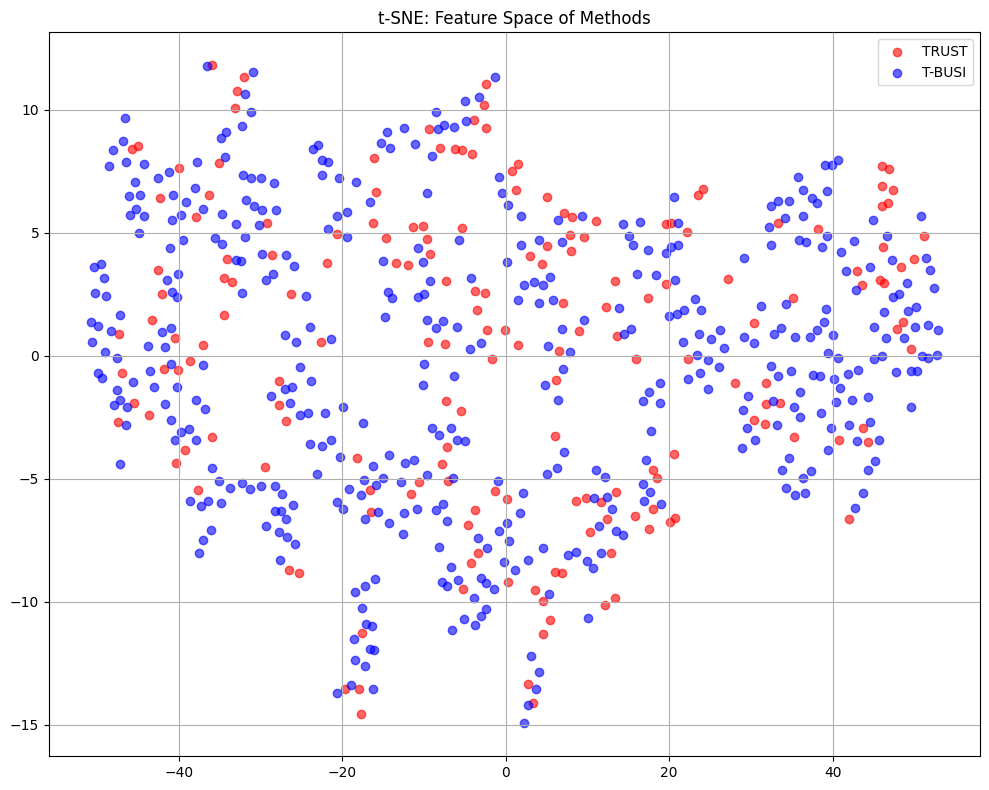

In [60]:
import os
import re
import torch
import timm
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# --- CONFIG ---
task = "UCLM2BUSI"
source_name = task.split("2")[0]
target_name = task.split("2")[1]
TRUST_txtpath = f'/mnt/HDD1/tuong/TRUST/baseline_TR_semi_AP/cp_{task}_TR_semi20_AP_1024/log.txt'

# --- READ BEST STEP ---
with open(TRUST_txtpath, "r", encoding="utf-8") as f:
    lines = f.readlines()
for line in reversed(lines):
    match = re.search(r"Best accuracy at (\d+)", line)
    if match:
        best_step = int(match.group(1)) / 1000
        break

# --- PATHS ---
method_dirs = {
    # 'TRUST': f'/mnt/HDD1/tuong/TRUST/baseline_TR_semi_AP/cp_{task}_TR_semi20_AP_1024/results/results_{best_step}k',
    'TRUST': f'/mnt/HDD1/tuong/TRUST/baseline_TR_semi_AP/results/{task}',
    # f'S-{source_name}': f'/mnt/HDD1/tuong/TRUST/dataset/Breast-{source_name}/train/imgs',
    # 'S2WAT': f'/mnt/HDD1/tuong/S2WAT/checkpoints/{task}/results_5.0k',
    # 'TransColor': f'/mnt/HDD1/tuong/TransColor/output/Breast_{task.replace("2", "-")}',
}
target_dir = f'/mnt/HDD1/tuong/TRUST/dataset/Breast-{target_name}/train/imgs'
checkpoint_path = f"/mnt/HDD1/tuong/TRUST/downstream/classification/checkpoints/vit_Breast-{target_name}/best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

# --- TRANSFORM ---
def val_transform(resize_size=256, crop_size=224):
    return transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# --- DATASET with label & method ---
class ImageFolderWithMethodAndLabel(Dataset):
    def __init__(self, folder, method_label, transform):
        self.samples = []
        for fname in os.listdir(folder):
            if not fname.endswith(('.jpg', '.png')):
                continue
            fname_lower = fname.lower()
            if 'benign' in fname_lower:
                label = 0
            elif 'malignant' in fname_lower:
                label = 1
            self.samples.append((os.path.join(folder, fname), method_label, label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, method_label, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        return image, method_label, label

# --- LOAD DATASETS ---
datasets = []
method_labels = list(method_dirs.keys()) + [f'T-{target_name}']
method_accuracy = {label: {"correct": 0, "total": 0} for label in method_labels}

for method_id, (name, path) in enumerate(method_dirs.items()):
    dataset = ImageFolderWithMethodAndLabel(path, method_id, val_transform())
    datasets.append(dataset)

# Add target domain
target_dataset = ImageFolderWithMethodAndLabel(target_dir, len(method_dirs), val_transform())
datasets.append(target_dataset)

# Concat
combined_dataset = ConcatDataset(datasets)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=False, drop_last=False)

# --- LOAD MODEL ---
model = timm.create_model('timm/vit_base_patch16_224.orig_in21k_ft_in1k', pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# --- RUN INFERENCE & TRACK ACCURACY ---
all_features, all_methods = [], []

with torch.no_grad():
    for imgs, method_ids, labels in tqdm(combined_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)

        for mid, pred, true in zip(method_ids, preds, labels):
            label = method_labels[mid]
            method_accuracy[label]["correct"] += (pred == true).item()
            method_accuracy[label]["total"] += 1

        feats = model(imgs)
        # feats = model.forward_features(imgs)[:, 0, :]  # CLS token
        # feats = model.forward_head(feats, pre_logits=True)
        all_features.append(feats.cpu())
        all_methods.append(method_ids)

all_features = torch.cat(all_features).numpy()
all_methods = torch.cat(all_methods).numpy()

# --- PRINT ACCURACY ---
print("\nAccuracy per method:")
for method_name, stats in method_accuracy.items():
    total = stats["total"]
    correct = stats["correct"]
    acc = 100 * correct / total if total > 0 else 0
    print(f"{method_name}: {acc:.2f}% ({correct}/{total})")

# --- t-SNE ---
features_2d = TSNE(n_components=2, random_state=42).fit_transform(all_features)

# --- PLOT ---
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for method_id in np.unique(all_methods):
    idxs = all_methods == method_id
    plt.scatter(features_2d[idxs, 0], features_2d[idxs, 1],
                alpha=0.6, label=method_labels[method_id],
                color=colors[method_id % len(colors)])

plt.title('t-SNE: Feature Space of Methods')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3D

100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


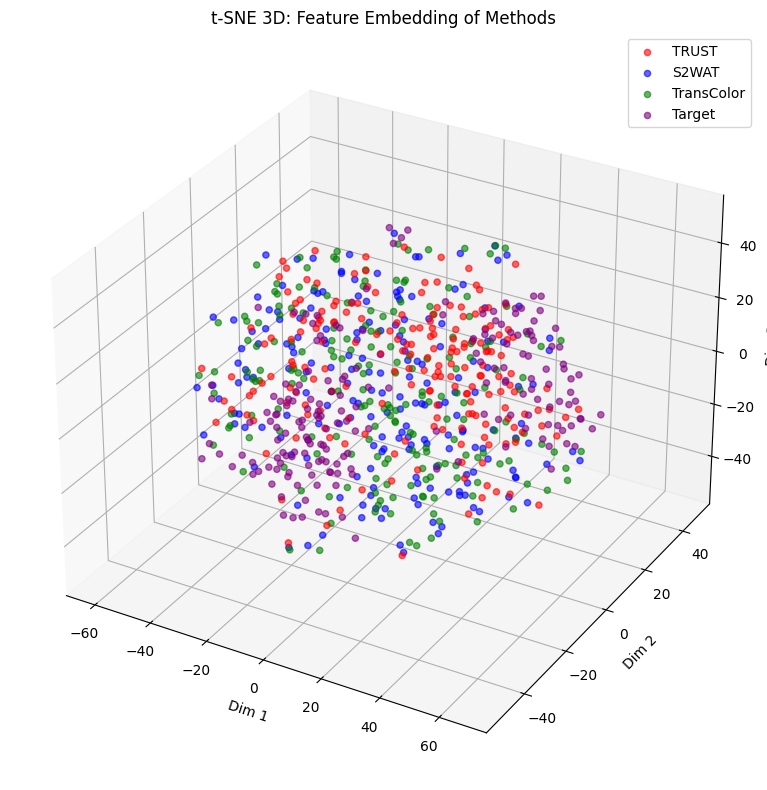

In [19]:
import os
import torch
import timm
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from mpl_toolkits.mplot3d import Axes3D

# --- CONFIG ---
method_dirs = {
    'TRUST':    '/mnt/HDD1/tuong/TRUST/baseline_TR_semi_AP/cp_BUSI2UCLM_TR_semi20_AP_1024/results/results_15.0k',
    'S2WAT':       '/mnt/HDD1/tuong/S2WAT/checkpoints/BUSI2UCLM/results_20.0k',
    'TransColor':  '/mnt/HDD1/tuong/TransColor/output/Breast_BUSI-UCLM'
}
target_dir = '/mnt/HDD1/tuong/TRUST/dataset/Breast-UCLM/train/imgs'
checkpoint_path = "/mnt/HDD1/tuong/TRUST/downstream/classification/checkpoints/vit_Breast-UCLM/best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

# --- TRANSFORM ---
def val_transform(resize_size=256, crop_size=224):
    return transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

# --- CUSTOM DATASET (method only) ---
class ImageFolderWithMethod(Dataset):
    def __init__(self, folder, method_label, transform):
        self.samples = []
        for fname in os.listdir(folder):
            if fname.endswith(('.jpg', '.png')):
                self.samples.append((os.path.join(folder, fname), method_label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, method_label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        return image, method_label

# --- LOAD DATASETS ---
datasets = []
method_labels = list(method_dirs.keys()) + ['Target']

for method_id, (name, path) in enumerate(method_dirs.items()):
    dataset = ImageFolderWithMethod(path, method_id, val_transform())
    datasets.append(dataset)

# Target images
target_dataset = ImageFolderWithMethod(target_dir, len(method_dirs), val_transform())
datasets.append(target_dataset)

combined_dataset = ConcatDataset(datasets)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=False)

# --- LOAD MODEL ---
model = timm.create_model('timm/vit_base_patch16_224.orig_in21k_ft_in1k', pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

# --- EXTRACT FEATURES ---
all_features, all_methods = [], []

with torch.no_grad():
    for imgs, methods in tqdm(combined_loader):
        imgs = imgs.to(device)
        feats = model.forward_features(imgs)[:, 0, :]  # CLS token
        all_features.append(feats.cpu())
        all_methods.append(methods)

all_features = torch.cat(all_features).numpy()
all_methods = torch.cat(all_methods).numpy()

# --- t-SNE 3D ---
features_3d = TSNE(n_components=3, random_state=42, perplexity=30).fit_transform(all_features)

# --- 3D VISUALIZATION ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'purple']
for method_id in np.unique(all_methods):
    idxs = all_methods == method_id
    ax.scatter(features_3d[idxs, 0], features_3d[idxs, 1], features_3d[idxs, 2],
               alpha=0.6, label=method_labels[method_id],
               color=colors[method_id % len(colors)])

ax.set_title('t-SNE 3D: Feature Embedding of Methods')
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
ax.legend()
plt.tight_layout()
plt.show()
